In [1]:
import os.path
import time

import torch
torch.cuda.empty_cache()

# Imports


In [1]:
from src.efficentnet_train import data_load,models_train,visualization,utils,generate_dataset,evaluation
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from src.efficentfacenet import face_descriptor
from torchvision import transforms
import pandas as pd



In [2]:
dataset_path = "../dataset/preprocessed/img_celeb_full"
model_weights_path="../model_weights/training"
train_data_save_path="../training log"
batch_size=8
stop_n_layers=5

In [7]:
train_history=pd.read_csv(train_data_save_path+"/train_data.csv",index_col=False)

In [4]:
train_history

,Train Loss,no train rows,Test Loss,No test rows,Time taken (M),Notes,Date,Time
0,0.280173,100000,0.342320,25000,65.2,remove sigmoid from classifier + input normali...,15/05/2022,23:26:00
1,0.989897,100000,1.000320,25000,60.1,remove sigmoid from classifier + input normali...,16/05/2022,0:27:00
2,1.000000,100000,1.000320,25000,60.2,remove sigmoid from classifier + input normali...,16/05/2022,1:27:00
3,0.173325,50000,0.284327,10000,63.0,remove sigmoid from classifier + input normali...,16/05/2022,19:28:00
4,0.243919,50000,0.281481,10000,60.0,remove sigmoid from classifier + input normali...,16/05/2022,20:28:00
...,...,...,...,...,...,...,...,...
141,0.099156,10000,0.173237,2500,18.4,"Classifier -->(1280,256,128)+ full train , ran...",21/05/2022,11:59:00
142,0.098474,10000,0.151633,2500,19.1,"Classifier -->(1280,256,128)+ full train , ran...",21/05/2022,12:19:00
143,0.093220,10000,0.161684,2500,20.1,"Classifier -->(1280,256,128)+ full train , ran...",21/05/2022,12:39:00
144,0.099141,10000,0.121382,2500,20.0,"Classifier -->(1280,256,128)+ full train , ran...",21/05/2022,12:59:00


# Load Data

In [3]:
train_transform = transforms.Compose([transforms.ToTensor(),transforms.RandomHorizontalFlip(),transforms.RandomRotation(10),transforms.RandomAutocontrast(),data_load.Normalize()])
test_transform=transforms.Compose([transforms.ToTensor(),data_load.Normalize()])

# Face descriptor model train

In [5]:
train_dataset = data_load.FacesTripletDataset(f"{dataset_path}/train", 5000, train_transform,False)
test_dataset=data_load.FacesTripletDataset(f"{dataset_path}/test", 1000, test_transform,False)


In [6]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
ts=time.time()
a_batch, p_batch, n_batch = next(iter(train_loader))
print(time.time()-ts)
for i in range(batch_size):
    fig, ax = plt.subplots(1, 3)
    ax[0].set_title("anchor")
    ax[0].imshow(a_batch[i].numpy().transpose([1,2,0]))


    ax[1].set_title("positive")
    ax[1].imshow(p_batch[i].numpy().transpose([1,2,0]))



    ax[2].set_title("negative")
    ax[2].imshow(n_batch[i].numpy().transpose([1,2,0]))



In [7]:
model = face_descriptor.FaceDescriptorModel(download_weights=True, version="efficientnet_b1")



In [7]:
model

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(
 

In [8]:
for i in range (len(model.features)):
      for parm in model.features[i].parameters():
            parm.requires_grad=True

In [19]:
for i in range(stop_n_layers):
  for parm in model.features[i].parameters():
    parm.requires_grad=True


In [8]:
epochs=15
learning_rate=0.001
train_notes="Classifier -->(1280,256,128)+ full train , randomHorizontal flip,random Rotation , randomAutoContrast,effnetb1 , learnrate =0.0001 full dataset"


In [9]:
# model.load_local_weights("../model_weights/training/05_25 22_43 Train_(0.019421) Test_(0.015686).pt",True)
model.load_local_weights("../model_weights/training/05_26 08_09 Train_(0.026858) Test_(0.019528).pt",True)

In [19]:
train_losses=models_train.model_train(model,epochs=1000,learn_rate=0.0001,train_loader=train_loader,test_loader=test_loader,train_mod="triplet",cuda=True,weight_saving_path=model_weights_path,epoch_data_saving_path=train_data_save_path,notes=train_notes)

Testing before training ...
 Testing  [==========] time remaining = 0.0 Avg Test_Loss=0.024072Test Loss before Training=0.02407247132062912
 epoch 1 [..........] time remaining = 13.38021 Avg Train_Loss=0.0

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 4.00 GiB total capacity; 3.47 GiB already allocated; 0 bytes free; 3.53 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [15]:
model.load_local_weights(model_weights_path+"/05_25 22_43 Train_(0.019421) Test_(0.015686).pt",cuda_weights=True)

# Face descriptor evaluation

In [16]:
features_dict=data_load.get_pic_features_dict(f"{dataset_path}/test",model,test_transform,cuda=True)

 data processed [==========] time remaing=0.008

In [11]:
utils.save_dict_to_json("face_features.json",features_dict)

NameError: name 'features_dict' is not defined

In [10]:
features_dict=imgs_features_dict=utils.load_dict_from_json("face_features.json")


In [11]:
test_data_pd_full=pd.DataFrame(generate_dataset.generate_testing_data_set_frame(dataset_path+"/test",True))

In [20]:
test_data_pd=test_data_pd_full.iloc[:300000,:]

In [21]:
evaluation.model_test(features_dict,test_data_pd,results_path="",threshold=5.1)

 Testing  [==========] time remaining = 0.0 Accuracy =88.103Accuracy now equal --> 88.1033%


(                              Mertic          Value
 0                     processed rows  300000.000000
 1  Model accuracy on Proceed Faces %      88.103000
 2                     False Positive   19834.000000
 3                     False Negative   15856.000000
 4                          precision       0.871184
 5                             recall       0.894287
 6                        fbeta-score       0.461090
 7           avg same person distance       3.349848
 8           avg diff person distance       8.318809
 9                    Model tolerance       5.100000,
                  Actual True  Actual False
 Predicted True        134144         19834
 Predicted False        15856        130166)

# Efficient-Facenet model train
- the trained descriptor + classifier

In [4]:
descriptor_weights="../model_weights/training/05_26 08_09 Train_(0.026858) Test_(0.019528).pt"

In [5]:
pair_train_dataset=data_load.FacesPairDataset(f"{dataset_path}/train",5000,train_transform)
pair_test_dataset=data_load.FacesPairDataset(f"{dataset_path}/test",1000,test_transform)

In [6]:
pair_train_loader=DataLoader(pair_train_dataset,128,shuffle=False)
pair_test_loader=DataLoader(pair_test_dataset,128,shuffle=False)

In [38]:
itr=iter(pair_train_dataset)

In [42]:
face_x,face_y,label=next(itr)

In [9]:
face_x.shape

torch.Size([3, 240, 240])

In [7]:
efficient_facenet=face_descriptor.EfficientFacenet(128,descriptor_weights)

In [32]:
for i in range(4):
    for param in efficient_facenet.descriptor.features[i]:
        param.requires_grad=False

In [8]:
for param in efficient_facenet.descriptor.parameters():
    param.requires_grad=False

In [9]:
train_notes="efficient facenet stop the descriptor feature extractor  and train  classifier model on full img_net photos "
model_weights_path="../model_weights/efficient_facenet"

In [19]:
models_train.model_train(efficient_facenet,100,0.001,pair_train_loader,pair_test_loader,"pair",cuda=True,weight_saving_path=model_weights_path,epoch_data_saving_path=train_data_save_path,notes=train_notes)

Testing before training ...
 Testing  [==========] time remaining = 0.0 Avg Test_Loss=0.005374Test Loss before Training=0.005503560781478882
 epoch 1 [==========] time remaining = 0.0 Avg Train_Loss=0.00467604539
 Testing  [==========] time remaining = 0.0 Avg Test_Loss=0.00903708755
 epoch 1 train_loss =0.0047882760345935825 test_loss=0.009254528284072876
!!!Warning Overfitting!!!
 epoch 2 [==========] time remaining = 0.0 Avg Train_Loss=0.00408704129
 Testing  [==========] time remaining = 0.0 Avg Test_Loss=0.00666106858
 epoch 2 train_loss =0.004185780119895935 test_loss=0.006821429252624512
!!!Warning Overfitting!!!
 epoch 3 [==========] time remaining = 0.0 Avg Train_Loss=0.00356003611
 Testing  [==========] time remaining = 0.0 Avg Test_Loss=0.00571205761
 epoch 3 train_loss =0.003645743617415428 test_loss=0.005849219918251038
!!!Warning Overfitting!!!
 epoch 4 [==========] time remaining = 0.0 Avg Train_Loss=0.00410903996
 Testing  [==========] time remaining = 0.0 Avg Test_Loss

KeyboardInterrupt: 

In [10]:
efficient_facenet.load_local_weights("../model_weights/efficient_facenet/05_26 13_58 Train_(0.003888) Test_(0.005116).pt",True)

In [12]:
lfw_data_path="../dataset/preprocessed/lfw_prep"
imgs_features_dict=data_load.get_pic_features_dict(lfw_data_path,model=efficient_facenet.descriptor,transform=test_transform,cuda=True)

 data processed [==========] time remaing=0.000

In [14]:
imgs_features_dict=utils.load_dict_from_json("face_features.json")

In [19]:
utils.save_dict_to_json("face_features.json",imgs_features_dict)


NameError: name 'imgs_features_dict' is not defined

In [11]:
imgs_features_dict=utils.load_dict_from_json("face_features.json")

In [13]:
full_test_data_pd=pd.DataFrame(generate_dataset.generate_testing_data_set_frame(lfw_data_path,True))

In [14]:
efficient_facenet.cuda()

EfficientFacenet(
  (descriptor): FaceDescriptorModel(
    (features): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): ConvNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
           

In [18]:
test_data_pd=full_test_data_pd.iloc[:100000,:]

In [21]:
error_table, confusion_table=evaluation.model_test(imgs_features_dict,test_data_pd,results_path="",threshold=0.15,classifier=efficient_facenet.classify_face_features,cuda=True)

 Testing  [..........] time remaining = 3.899378 Accuracy =42.085

KeyboardInterrupt: 

In [20]:
error_table

,Mertic,Value
0,processed rows,100000.0
1,Model accuracy on Proceed Faces %,46.926
2,False Positive,3212
3,False Negative,49862
4,precision,0.041182
5,recall,0.00276
6,fbeta-score,0.00014
7,avg same person distance,[0.102968186]
8,avg diff person distance,[0.2269968]
9,Model tolerance,0.55


In [ ]:
error_table

In [14]:
import torch
x=torch.tensor([1,2])
y=[1,2]

In [16]:
print(isinstance(y,torch.Tensor))

False


In [17]:
x.numpy()

array([1, 2], dtype=int64)

In [34]:
test_data_pd.head()

,0,1,2
0,9236/042921.jpg,9236/052346.jpg,1
1,9236/042921.jpg,8647/101929.jpg,0
2,9236/042921.jpg,9236/071430.jpg,1
3,9236/042921.jpg,281/129193.jpg,0
4,9236/042921.jpg,9236/082375.jpg,1


In [72]:
efficient_facenet.cpu()

EfficientFacenet(
  (descriptor): FaceDescriptorModel(
    (features): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): ConvNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
           

In [75]:
s=77
e=100

In [76]:
for idx in range(s,e):
    face_x_path,face_y_path=f"{dataset_path}/test/{test_data_pd.iloc[idx][0]}",f"{dataset_path}/test/{test_data_pd.iloc[idx][1]}"
    label=test_data_pd.iloc[idx][2]

    face_x_img,face_y_img=data_load.load_image(face_x_path,test_transform,True),data_load.load_image(face_y_path,test_transform,True)
    pred=efficient_facenet.identify_faces(face_x_img,face_y_img)

    print(f"predicted Value={pred} actual={label}")

predicted Value=tensor([[0.3371]]) actual=0
predicted Value=tensor([[0.4702]]) actual=1
predicted Value=tensor([[0.3703]]) actual=0
predicted Value=tensor([[0.4486]]) actual=1
predicted Value=tensor([[0.4651]]) actual=0
predicted Value=tensor([[0.4499]]) actual=1
predicted Value=tensor([[0.4050]]) actual=0
predicted Value=tensor([[0.4802]]) actual=1
predicted Value=tensor([[0.3835]]) actual=0
predicted Value=tensor([[0.4892]]) actual=1
predicted Value=tensor([[0.5524]]) actual=0
predicted Value=tensor([[0.4532]]) actual=1
predicted Value=tensor([[0.3331]]) actual=0
predicted Value=tensor([[0.4790]]) actual=1
predicted Value=tensor([[0.3585]]) actual=0
predicted Value=tensor([[0.4496]]) actual=1
predicted Value=tensor([[0.4562]]) actual=0
predicted Value=tensor([[0.4713]]) actual=1
predicted Value=tensor([[0.4419]]) actual=0
predicted Value=tensor([[0.4394]]) actual=1
predicted Value=tensor([[0.3617]]) actual=0
predicted Value=tensor([[0.4720]]) actual=1
predicted Value=tensor([[0.5614]

tensor([[0.8023]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.08477306365966797
predicted Value=tensor([0.9411]) actual=tensor([1.])


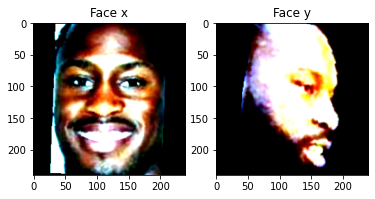

In [73]:
import time
ts=time.time()
face_x_img, face_y_img, label = next(iter(pair_test_loader))
print(time.time()-ts)
i=6
fig, ax = plt.subplots(1, 2)
ax[0].set_title("Face x")
ax[0].imshow(face_x_img[i].numpy().transpose([1,2,0]))


ax[1].set_title("Face y")
ax[1].imshow(face_y_img[i].numpy().transpose([1,2,0]))

pred=efficient_facenet.identify_faces(face_x_img,face_y_img)
print(f"predicted Value={pred[i]} actual={label[i]}")


